## Importing Libraries

In [1]:
import pandas as pd
import numpy as np


import os
import wave
from IPython.display import Audio
from numpy import sum,isrealobj,sqrt
from numpy.random import standard_normal

     
import warnings
warnings.filterwarnings("ignore")

In [ ]:
%cd DSERb-MIDCA

In [5]:
file_source =pd.read_csv("/content/DSER-MIDCA/file_source.csv")

In [8]:

import librosa
import librosa.display


## Viewing sample data

In [23]:
sample_data = file_source.sample(n=1)

In [27]:
sample_rate = file_source["Sample Rate"].min()
sample_rate

16000

In [10]:

def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveplot(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
  
    plt.colorbar()

In [29]:
emotion= sample_data["Emotions"].tolist()[0]
path = sample_data["Path"].tolist()[0] 


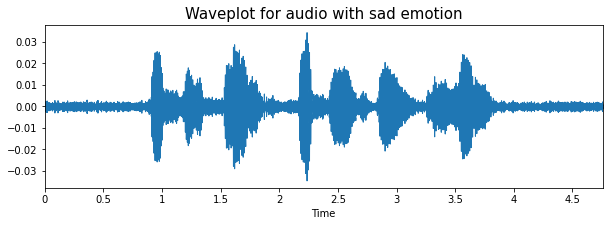

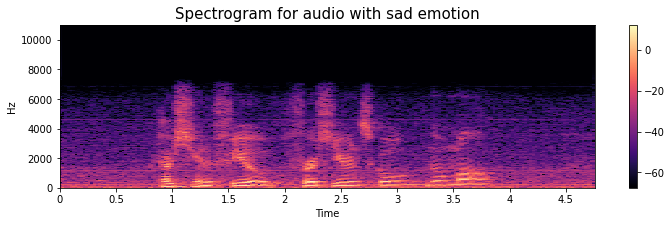

In [30]:
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

In [11]:
import seaborn as sn
from scipy.stats import norm
import scipy.signal as sig
import copy


In [32]:
data, sampling_rate = librosa.load(path)
sampling_rate

22050

## AWGN 

In [12]:
def signaltonoise(a, axis=0, ddof=0, db=True):
    """
    The signal-to-noise ratio of the input data.
    Returns the signal-to-noise ratio of `a`, here defined as the mean
    divided by the standard deviation.
    Parameters
    ----------
    a : array_like
        An array_like object containing the sample data.
    axis : int or None, optional
        If axis is equal to None, the array is first ravel'd. If axis is an
        integer, this is the axis over which to operate. Default is 0.
    ddof : int, optional
        Degrees of freedom correction for standard deviation. Default is 0.
    Returns
    -------
    s2n : ndarray
        The mean to standard deviation ratio(s) along `axis`, or 0 where the
        standard deviation is 0.
    """
    a = np.asanyarray(a)
    m = a.mean(axis)
    sd = a.std(axis=axis, ddof=ddof)
    if db:  
      return 20*np.log10(abs(np.where(sd == 0, 0, m/sd)))
    else:
      return np.where(sd == 0, 0, m/sd)
    
     


In [13]:
def awgn(s,SNRdB=None,L=1):
    """
    AWGN channel
    Add AWGN noise to input signal. The function adds AWGN noise vector to signal 's' to generate a resulting signal vector 'r' of specified SNR in dB. It also
    returns the noise vector 'n' that is added to the signal 's' and the power spectral density N0 of noise added
    Parameters:
        s : input/transmitted signal vector
        SNRdB : desired signal to noise ratio (expressed in dB) for the received signal
        L : oversampling factor (applicable for waveform simulation) default L = 1.
    Returns:
        r : received signal vector (r=s+n)
"""
    if SNRdB is None:
      SNRdB=signaltonoise(s)
    # print("SNRdB",SNRdB)
    gamma = 10**(SNRdB/10) #SNR to linear scale
    if s.ndim==1:# if s is single dimensional vector
        P=L*sum(abs(s)**2)/len(s) #Actual power in the vector
    else: # multi-dimensional signals like MFSK
        P=L*sum(sum(abs(s)**2))/len(s) # if s is a matrix [MxN]
    N0=P/gamma # Find the noise spectral density
    if isrealobj(s):# check if input is real/complex object type
        n = sqrt(N0/2)*standard_normal(s.shape) # computed noise
    else:
        n = sqrt(N0/2)*(standard_normal(s.shape)+1j*standard_normal(s.shape))
    r = s + n  # received signal
    return r
     


In [35]:
data_with_noise = awgn(data,10)

## Sample with AWGN

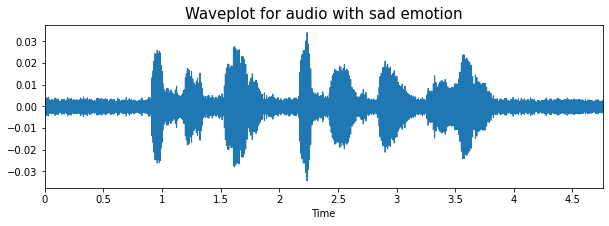

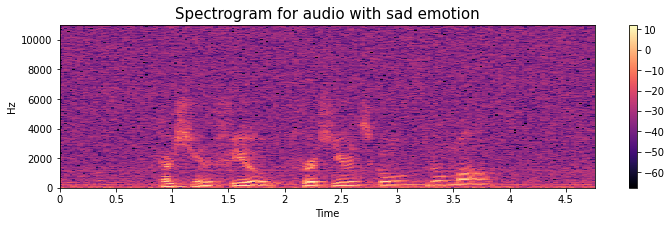

In [36]:
create_waveplot(data_with_noise, sampling_rate, emotion)
create_spectrogram(data_with_noise, sampling_rate, emotion)
Audio(data_with_noise, rate=sampling_rate)

In [14]:
def mfcc_extract(filename,sample_rate = None):
    try:
        y, sr  = librosa.load(filename)
        if sample_rate is None:
          mfcc = librosa.feature.mfcc(y=y, sr=sr)
        else:
          mfcc = librosa.feature.mfcc(y=y, sr=sample_rate)
        return mfcc
    except Exception as ex:
        print("File:",filename, "Exception :",ex)
        return None
     

## Removing Silence

In [16]:
from pydub import AudioSegment

def detect_leading_silence(sound, silence_threshold=-50.0, chunk_size=10):
    '''
    sound is a pydub.AudioSegment
    silence_threshold in dB
    chunk_size in ms

    iterate over chunks until you find the first one with sound
    '''
    trim_ms = 0 # ms

    assert chunk_size > 0 # to avoid infinite loop
    while sound[trim_ms:trim_ms+chunk_size].dBFS < silence_threshold and trim_ms < len(sound):
        trim_ms += chunk_size

    # if there is no end it should return the length of the segment
    return min(trim_ms, len(sound))



In [42]:
sound = AudioSegment.from_file(path, format="wav")
start_trim = detect_leading_silence(sound)
end_trim = detect_leading_silence(sound.reverse())
duration = len(sound)    
print(duration,start_trim,end_trim)
trimmed_sound = sound[start_trim:duration-end_trim]
trimmed_sound

4760 910 1040


## Get Audio Length

In [19]:
file_source["Audio Length"]=None
for idx, row in tqdm(file_source.iterrows(),total=len(file_source)):
  file_source.at[idx,"Audio Length"] = librosa.get_duration(filename=(row.Path))


  0%|          | 0/9987 [00:00<?, ?it/s]

In [20]:
file_source["Audio Length"].value_counts()

3.503500    66
3.737062    61
3.670333    60
3.570229    56
3.603604    52
            ..
5.716000     1
3.339125     1
2.600125     1
5.528688     1
1.681688     1
Name: Audio Length, Length: 5135, dtype: int64

In [21]:
file_source["Audio Length"].astype(int).describe()

count    9987.000000
mean        3.804246
std         2.826591
min         0.000000
25%         2.000000
50%         3.000000
75%         5.000000
max        34.000000
Name: Audio Length, dtype: float64

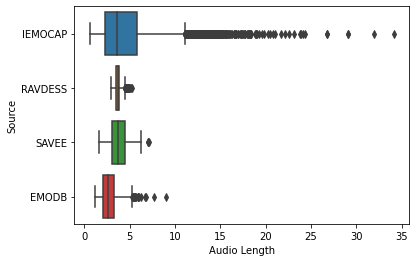

In [22]:
import seaborn as sns
sns.boxplot(x = "Audio Length", y="Source", data =file_source )

## Applying Trimming to the signal

In [23]:
from pathlib import Path

In [24]:
file_source["Trimmed Path"] = file_source["Path"].apply(lambda x : x.replace("/content/DSER-MIDCA/data/","/content/DSER-MIDCA/trimmed/"))

In [25]:
file_source["Trimmed 10db AWGN Path"] = file_source["Path"].apply(lambda x : x.replace("/content/DSER-MIDCA/data/","/content/DSER-MIDCA/awgn_trimmed_10db/"))

In [26]:
file_source["Trimmed 20db AWGN Path"] = file_source["Path"].apply(lambda x : x.replace("/content/DSER-MIDCA/data/","/content/DSER-MIDCA/awgn_trimmed_20db/"))

In [57]:
from pathlib import Path

for idx, row in tqdm(file_source.iterrows(),total=len(file_source)):
  Path(row["Trimmed Path"].replace(row.Filename,"")).mkdir(parents=True, exist_ok=True)

  0%|          | 0/9987 [00:00<?, ?it/s]

In [58]:
for idx, row in tqdm(file_source.iterrows(),total=len(file_source)):
  Path(row["Trimmed 10db AWGN Path"].replace(row.Filename,"")).mkdir(parents=True, exist_ok=True)

  0%|          | 0/9987 [00:00<?, ?it/s]

In [64]:
for idx, row in tqdm(file_source.iterrows(),total=len(file_source)):
  Path(row["Trimmed 20db AWGN Path"].replace(row.Filename,"")).mkdir(parents=True, exist_ok=True)

  0%|          | 0/9987 [00:00<?, ?it/s]

In [59]:
trimmed_non_zero=[]
trimmed_actual = []
for idx, row in tqdm(file_source.iterrows(),total=len(file_source)):
  sound = AudioSegment.from_file(row["Path"], format="wav")

  start_trim = detect_leading_silence(sound)
  end_trim = detect_leading_silence(sound.reverse())

  duration = len(sound)    

  trimmed_sound = sound[start_trim:duration-end_trim]
  if len(trimmed_sound)>0:
    trimmed_sound.export(row["Trimmed Path"], format="wav")
    trimmed_non_zero.append(row["Trimmed Path"])
  else:
    sound.export(row["Trimmed Path"], format="wav")
    trimmed_actual.append(row["Trimmed Path"])

  0%|          | 0/9987 [00:00<?, ?it/s]

In [60]:
len(trimmed_non_zero), len(trimmed_actual)

(9964, 23)

In [61]:
import random
path = random.sample(trimmed_non_zero,1)[0]
actual = path.replace("trimmed","data")

In [ ]:
actual

'/content/DSER-MIDCA/data/IEMOCAP/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_F023.wav'

## Sample Preview of Silence Removal

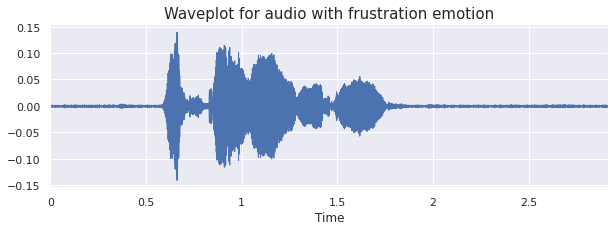

In [ ]:

data, sampling_rate = librosa.load(actual)
create_waveplot(data, sampling_rate, emotion)
Audio(actual)

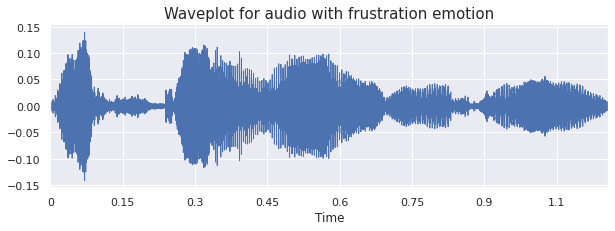

In [ ]:
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
Audio(path)

## Adding AWGN noise to the signal

In [62]:
import soundfile as sf

awgn_noise_db=10
for idx, row in tqdm(file_source.iterrows(),total=len(file_source)):
  data, sampling_rate = librosa.load(row.Path)
  audio_with_awgn = awgn(data,awgn_noise_db)
  sf.write(row["Trimmed 10db AWGN Path"], audio_with_awgn, sampling_rate)

  0%|          | 0/9987 [00:00<?, ?it/s]

In [65]:
awgn_noise_db=20
for idx, row in tqdm(file_source.iterrows(),total=len(file_source)):
  data, sampling_rate = librosa.load(row.Path)
  audio_with_awgn = awgn(data,awgn_noise_db)
  sf.write(row["Trimmed 20db AWGN Path"], audio_with_awgn, sampling_rate)

  0%|          | 0/9987 [00:00<?, ?it/s]

## Trimmed Audio Length

In [71]:
file_source["Trimmed Audio Length"]=None
for idx, row in tqdm(file_source.iterrows(),total=len(file_source)):
  file_source.at[idx,"Trimmed Audio Length"] = librosa.get_duration(filename=(row["Trimmed Path"]))


  0%|          | 0/9987 [00:00<?, ?it/s]

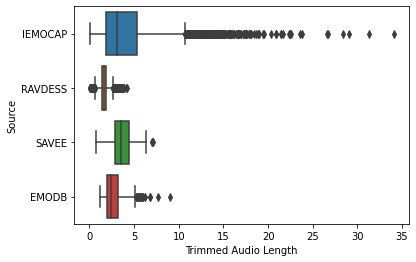

In [72]:
import seaborn as sns
sns.boxplot(x = "Trimmed Audio Length", y="Source", data =file_source )

In [73]:
file_source["Trimmed Audio Length"].astype(int).describe()

count    9987.00000
mean        3.09252
std         2.93242
min         0.00000
25%         1.00000
50%         2.00000
75%         4.00000
max        34.00000
Name: Trimmed Audio Length, dtype: float64